# GTO to manifold

We present an example going from GTO to a manifold insertion point. 
The actual trajectory is designed backward in time.

This example requires the [`polaris` repository](https://github.com/Yuricst/polaris) to construct manifolds. 

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import time 

import sys
sys.path.append("../../../")    # path to pyqlaw
import pyqlaw

In [2]:
import sys
sys.path.append("../../../../polaris")   # give path to polaris module

In [3]:
import polaris.SolarSystemConstants as ssc
import polaris.Propagator as prop
import polaris.R3BP as r3bp
import polaris.Keplerian as kepl
import polaris.Coordinates as coord
import polaris.LinearOrbit as lino

In [4]:
param_earth_moon = r3bp.CR3BP('399','301')   # NAIF ID's '399': Earth, '301': Moon
param_earth_moon.mu

0.012150584269940354

In [5]:
haloinit = r3bp.get_halo_approx(mu=param_earth_moon.mu, lp=1, lstar=param_earth_moon.lstar, 
                                az_km=12000, family=1, phase=0.0)

In [6]:
p_conv, state_conv, flag_conv = r3bp.ssdc_periodic_xzplane(param_earth_moon, haloinit["state_guess"], 
                                                           haloinit["period_guess"], fix="z", message=False)

In [7]:
prop0 = prop.propagate_cr3bp(param_earth_moon, state_conv, p_conv)

In [144]:
mnfpls, mnfmin = r3bp.get_manifold(param_earth_moon, state_conv, p_conv, tf_manif=6.1,
                                   stable=True, force_solve_ivp=False)

Manifold:   0%|          | 0/50 [00:00<?, ?it/s]

We now choose an insertion point to switch between coasting on the manifold and low-thrust spiral. 

In [147]:
index_departure = 3
x_insertion_EMrot = np.array([
    mnfmin.branches[index_departure].propout.xs[-1],
    mnfmin.branches[index_departure].propout.ys[-1],
    mnfmin.branches[index_departure].propout.zs[-1],
    mnfmin.branches[index_departure].propout.vxs[-1],
    mnfmin.branches[index_departure].propout.vys[-1],
    mnfmin.branches[index_departure].propout.vzs[-1],
])

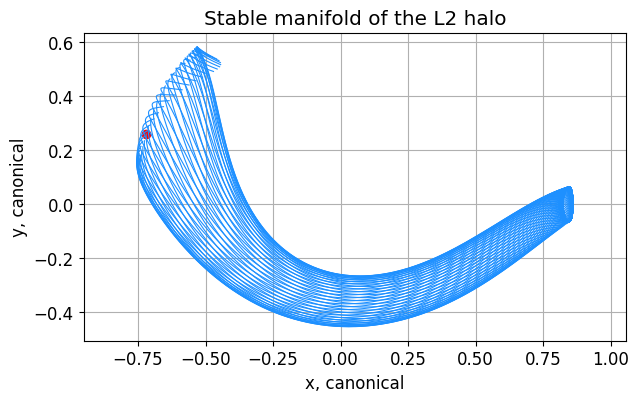

In [148]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(1,1, figsize=(7,4))
# for branch in mnfpls.branches:
#     ax.plot(branch.propout.xs, branch.propout.ys, linewidth=0.8, c='deeppink')    
for branch in mnfmin.branches:
    ax.plot(branch.propout.xs, branch.propout.ys, linewidth=0.8, c='dodgerblue')
ax.scatter(x_insertion_EMrot[0], x_insertion_EMrot[1], marker="o", color="red")
ax.set(xlabel='x, canonical', ylabel='y, canonical', title='Stable manifold of the L2 halo')
plt.grid(True)
plt.axis("equal")
plt.show()

In [149]:
def T_EMrot2Inr(theta, n=1.0):
    c = np.cos(theta)
    s = np.sin(theta)
    T = np.array([
        [ c,   -s,   0,  0,  0, 0],
        [ s,    c,   0,  0,  0, 0],
        [ 0,    0,   1,  0,  0, 0],
        [-n*s, -n*c, 0,  c, -s, 0],
        [ n*c, -n*s, 0,  s,  c, 0],
        [ 0,    0,   0,  0,  0, 1],
    ])
    return T

def T_Inr2EMrot(theta, n=1.0):
    c = np.cos(theta)
    s = np.sin(theta)
    T = np.array([
        [ c,   -s,   0,  0,  0, 0],
        [ s,    c,   0,  0,  0, 0],
        [ 0,    0,   1,  0,  0, 0],
        [-n*s, -n*c, 0,  c, -s, 0],
        [ n*c, -n*s, 0,  s,  c, 0],
        [ 0,    0,   0,  0,  0, 1],
    ])
    return np.linalg.inv(T)

In [150]:
T_EMrot2Inr_insertion = T_EMrot2Inr(0.0)
shift = np.array([param_earth_moon.mu, 0, 0, 0, 0, 0])
x_insertion_Inr = T_EMrot2Inr_insertion @ (x_insertion_EMrot + shift)

In [151]:
x_insertion_Inr

array([-0.70745582,  0.25978978,  0.03199177, -0.27696966, -0.93623785,
        0.03190293])

In [152]:
mu_Earth = 1 - param_earth_moon.mu
elts_dict = kepl.sv2elts(x_insertion_Inr, mu=mu_Earth)
alpha_insertion_Inr = np.array([
    elts_dict['sma'],
    elts_dict['ecc'],
    elts_dict['inc'],
    elts_dict['raan'],
    elts_dict['aop'],
    elts_dict['ta'],
])

In [153]:
alpha_insertion_Inr

array([0.59334358, 0.2779614 , 0.05526581, 1.91502655, 3.85197959,
       3.30659376])

In [177]:
# construct problem
#elements_type = "keplerian"
elements_type = "mee_with_a"

prob = pyqlaw.QLaw(
    mu = 1 - param_earth_moon.mu,
    elements_type=elements_type,
    integrator="rk4"
)

# initial and final elements: [a,e,i,RAAN,omega,ta]
oe0 = alpha_insertion_Inr
sma_gto = (6578+42164)/2/param_earth_moon.lstar
ecc_gto = (42164-6578) / (42164+6578)
# sma_gto = 42164/param_earth_moon.lstar
# ecc_gto = 0.01
oeT = np.array([
    sma_gto,
    ecc_gto,
    np.deg2rad(23.0),
    0.2,
    3.01,
    1.26
])

if elements_type == "mee_with_a":
    oe0 = pyqlaw.kep2mee_with_a(np.array(oe0))
    oeT = pyqlaw.kep2mee_with_a(np.array(oeT))
    woe = [3.0, 1.0, 1.0, 1.0, 1.0]
else:
    woe = [3.0, 1.0, 1.0, 0.0, 0.0]

In [179]:
woe

[3.0, 1.0, 1.0, 1.0, 1.0]

In [180]:
# spacecraft parameters
mass0 = 1.0
tmax = 0.15
mdot = 1e-4
tf_max = 3000.0
t_step = -0.05
# set problem
prob.set_problem(oe0, oeT, mass0, tmax, mdot, tf_max, t_step, woe=woe)
prob.pretty()

# solve
prob.solve()
prob.pretty_results()

Transfer:
  a  : 5.9334e-01 -> 6.3400e-02 (weight: 3.00)
  f  : 2.4175e-01 -> -7.2838e-01 (weight: 1.00)
  g  : -1.3719e-01 -> -4.9905e-02 (weight: 1.00)
  h  : -9.3277e-03 -> 1.9940e-01 (weight: 1.00)
  k  : 2.6018e-02 -> 4.0420e-02 (weight: 1.00)
Target elements successfully reached!
Exit code : 1
Converge  : True
Final state:
  a  : 6.3626e-02 (error: 2.2542e-04)
  f  : -7.2569e-01 (error: 2.6931e-03)
  g  : -5.0814e-02 (error: 9.0902e-04)
  h  : 1.9897e-01 (error: 4.2297e-04)
  k  : 4.0818e-02 (error: 3.9845e-04)
Transfer time : -23.000000000000192
Final mass    : 1.002300000000015


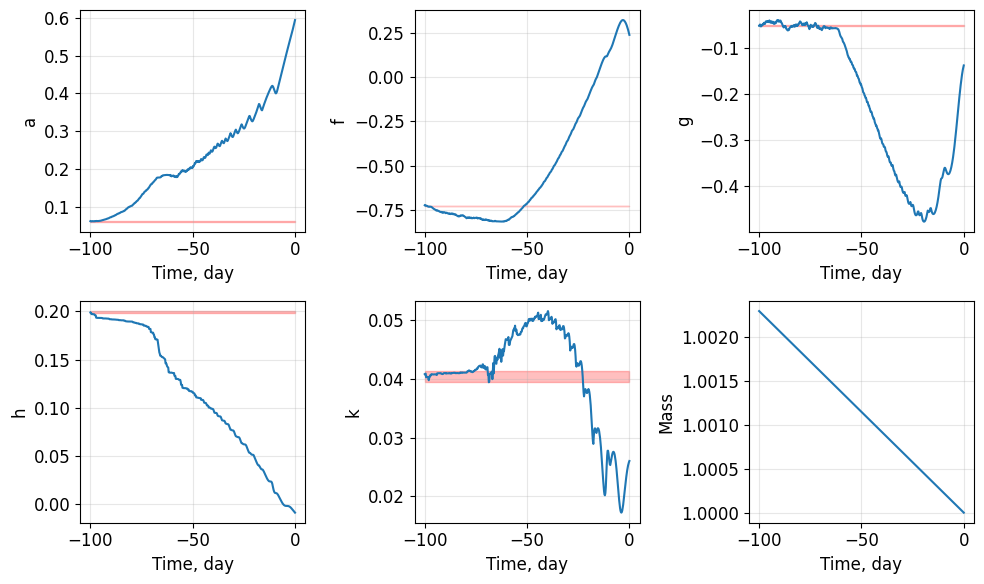

In [181]:
fig1, ax1 = prob.plot_elements_history(TU=param_earth_moon.tstar/86400,
                                       time_unit_name="day")

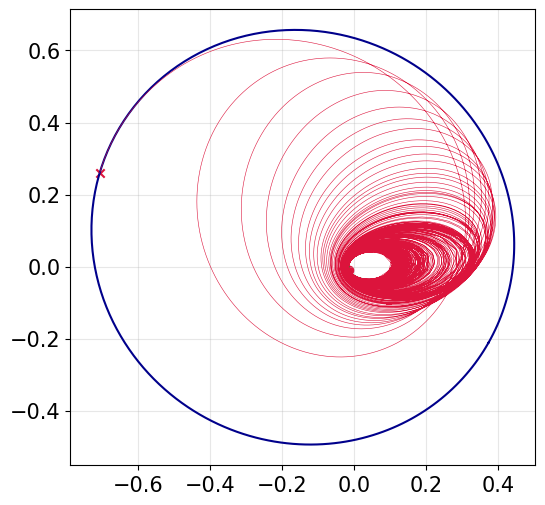

In [247]:
fig2, ax2 = prob.plot_trajectory_2d(interpolate=True, steps=30000)
ax2.grid(True, alpha=0.3)

In [204]:
cart, t_evals = prob.get_cartesian_history(interpolate=True, kind='linear',
                                  steps=40000, get_t_evals=True)
cart.shape

(6, 40000)

In [205]:
transfer_EMrot = np.zeros((6,cart.shape[1]))
shift_to_EMrot = np.array([-param_earth_moon.mu, 0, 0, 0, 0, 0])
for idx in range(cart.shape[1]):
    transfer_EMrot[:,idx] = T_Inr2EMrot(t_evals[idx]) @ cart[:,idx] + shift_to_EMrot

In [217]:
def circle_coordinates(center, radius, steps=200):
    coord = np.zeros((2,steps))
    thetas = np.linspace(0, 2*np.pi, steps)
    for idx in range(steps):
        coord[:,idx] = radius * np.array([np.cos(thetas[idx]), np.sin(thetas[idx])]) + np.array(center)
    return coord

earth_coord = circle_coordinates([-param_earth_moon.mu, 0], radius=6378/param_earth_moon.lstar)

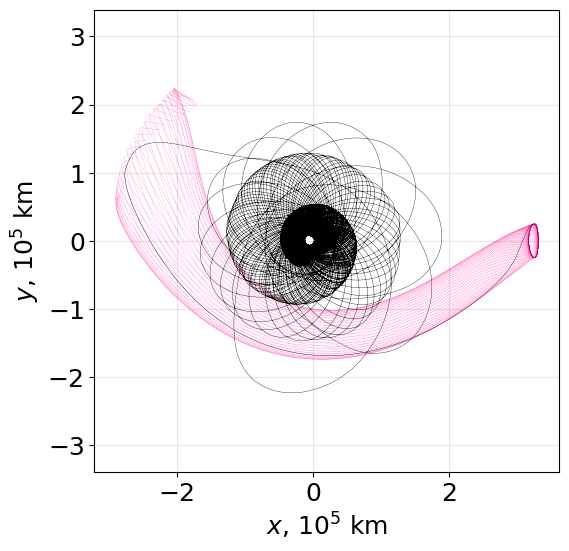

In [229]:
LU = param_earth_moon.lstar/1e5
plt.rcParams["font.size"] = 18
fig, ax = plt.subplots(1,1, figsize=(6,6))  
ax.grid(True, alpha=0.3)
for branch in mnfmin.branches:
    ax.plot(branch.propout.xs*LU, branch.propout.ys*LU, linewidth=0.1, c='deeppink')
    
ax.plot(mnfmin.branches[index_departure].propout.xs*LU,
        mnfmin.branches[index_departure].propout.ys*LU,
        linewidth=0.25, c='black')
ax.plot(transfer_EMrot[0,:]*LU, transfer_EMrot[1,:]*LU, linewidth=0.25, color='black')

ax.plot(earth_coord[0,:]*LU, earth_coord[1,:]*LU, c='dodgerblue', lw=0.1)

ax.set(xlabel='$x$, $10^5$ km', ylabel='$y$, $10^5$ km')
plt.axis("equal")
plt.savefig("example_gto_L1halo.png", dpi=500, bbox_inches='tight')
plt.show()

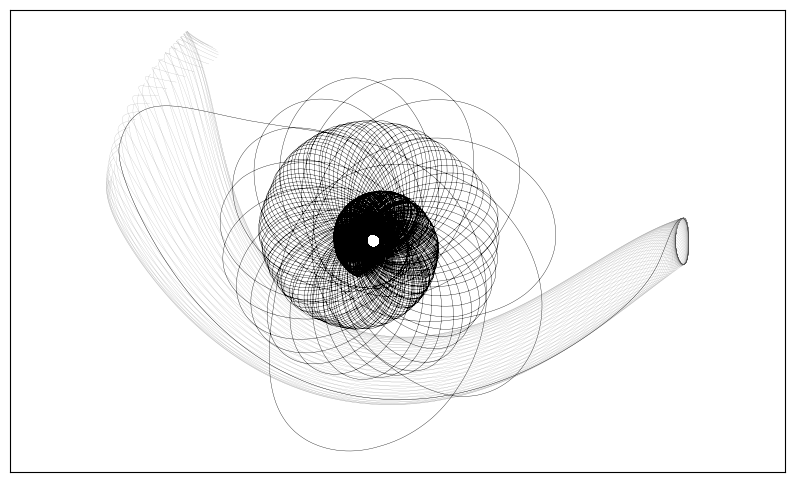

In [246]:
LU = param_earth_moon.lstar/1e5
plt.rcParams["font.size"] = 15
fig, ax = plt.subplots(1,1, figsize=(10,6))  
#ax.grid(True, alpha=0.01)
for branch in mnfmin.branches:
    ax.plot(branch.propout.xs*LU, branch.propout.ys*LU, linewidth=0.1, c='grey')
    
ax.plot(mnfmin.branches[index_departure].propout.xs*LU,
        mnfmin.branches[index_departure].propout.ys*LU,
        linewidth=0.25, c='black')
ax.plot(transfer_EMrot[0,:]*LU, transfer_EMrot[1,:]*LU, linewidth=0.25, color='black')

plt.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.axis("equal")
plt.savefig("example_gto_L1halo_tshirt.pdf", bbox_inches='tight')
plt.show()